In [1]:
import json
from gensim.utils import simple_preprocess
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans, KMeans, HDBSCAN, AgglomerativeClustering, FeatureAgglomeration, MeanShift
# from sklearn.tree import 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import spmatrix
from math import ceil

In [2]:
# nltk.download('stopwords')
from nltk.corpus import stopwords

# Import Documents

In [3]:
SERVICE_REQ_JSON_FILE_NAME = 'service_requests_last_90_days.json'

In [4]:
def extract_request_id_with_description(filename:str) -> dict:
    ''' 
    For a given file containing a JSON Array of Service Request JSON Objects, extract the service number and the description
    (if it exists) into a dictionary for further preprocessing.

    Returns: Dict (Service Request ID -> Service Request Description)
    '''
    request_id_descr_dict = {}
    service_requests_json = json.loads(open(filename, 'r').read())

    for service_request in service_requests_json:
        # Ensure the description exists for this service request
        description = service_request.get('description', False)
        if not description: continue   
        # status_notes = service_request.get('status_notes', False)
        # if status_notes:
        #     description = description + ' | ' + status_notes

        # Add to dictionary using service request ID as key and service request description as value.
        request_id_descr_dict[service_request['service_request_id']] = description

    return request_id_descr_dict

In [5]:
document_dictionary = extract_request_id_with_description(SERVICE_REQ_JSON_FILE_NAME)

# Pre-processing

## Stop word definition and removal
Along with the standard list of English stopwords, custom stopwords will be removed or masked.
Words with a frequency above 10 percent of the corpus size will be removed from each document.
Vehicle makes, models, and street names will be masked (replaced with <make>, <model>, <street>, respectively) to avoid unsupervised models from incorrectly learning these features as classes.

In [6]:
all_words_in_desc = [word for desc in document_dictionary.values() for word in simple_preprocess(desc)]

TEN_PCT_THRESHOLD = len(document_dictionary.values()) * 0.30

all_words_counts = np.unique(all_words_in_desc, return_counts=True)
all_words_counts_dict = {
    'words': all_words_counts[0],
    'counts': all_words_counts[1]
}
all_words_counts_df = pd.DataFrame(all_words_counts_dict)
all_words_counts_df = all_words_counts_df[all_words_counts_df.counts > TEN_PCT_THRESHOLD]
all_words_counts_df.sort_values('counts', inplace=True, ascending=False)
all_words_counts_df

,words,counts
3675,parked,6513
4984,the,5884
2510,in,4826
3682,parking,4206
753,car,3921
2613,is,3299
193,and,3229
3550,of,3181
5335,vehicle,2899


In [7]:
def replace_word_type(members, replacement, doc_tokens, keywords):
    '''
    Replace any token that is contained within members with the given replacement.
    Ensure that any given keywords are not masked.

    :param members: list of tokens that are members of this word type
    :param replacement: replacement token for any detected member token
    :param doc_tokens: list of tokens that make up a document
    :param keywords: list of keyword tokens that will not be masked
    :returns: list of document tokens with any tokens contained within member replaced with replacement
    '''
    protected_tokens = set(members) - set(keywords)
    return [token if token not in protected_tokens else replacement for token in doc_tokens]

In [8]:
test_members = ['car', 'truck']
test_doc_tokens = simple_preprocess('car and truck in the street')
replace_word_type(test_members, '<vehicle>', test_doc_tokens, [])

['<vehicle>', 'and', '<vehicle>', 'in', 'the', 'street']

Define lists of car makes and models, street names, and other features that we do not want the model to learn.

Car Makes and Models:

In [9]:
vehicle_makes_models_df = pd.concat([pd.read_csv(f'https://raw.githubusercontent.com/abhionlyone/us-car-models-data/master/{year}.csv?raw=true') for year in range(1992, 2027)])
vehicle_makes_models_df.head()

,year,make,model,body_styles
0,1992,Acura,Integra,"[""Sedan"", ""Hatchback""]"
1,1992,Acura,Legend,"[""Sedan"", ""Coupe""]"
2,1992,Acura,NSX,"[""Coupe""]"
3,1992,Acura,Vigor,"[""Sedan""]"
4,1992,Alfa Romeo,164,"[""Sedan""]"


In [10]:
vehicle_makes = [words for element in list(vehicle_makes_models_df.make.apply(str.lower).apply(simple_preprocess).apply(lambda l: str.join(' ', l)).unique()) for words in element.split()]
vehicle_models = [words for element in list(vehicle_makes_models_df.model.apply(str.lower).apply(simple_preprocess).apply(lambda l: str.join(' ', l)).unique()) for words in element.split()]

Street Names:

In [11]:
street_names_df = pd.read_csv('street_names.csv')
street_names_df.drop(columns=['Unnamed: 1'], axis=1, inplace=True)
street_names_list = [word for elements in list(street_names_df.name.apply(simple_preprocess).apply(lambda l: str.join(' ', l)).unique()) for word in elements.split()]

Custom stopword list consisting of standard English stopwords, high-frequency corpus words, and domain-specific stopwords.
Also make sure to not put any keywords into the stoplist.

In [12]:
keywords = ['bike', 'bus', 'hydrant', 'resident', 'nonresident', 'sticker', 'driveway', 'crosswalk', 'sidewalk', 'handicap', 'double']

STOP_LIST = stopwords.words('english') + list(all_words_counts_df['words']) + ['illegal', 'parking', 'constituent', 'en', 'translated', 'auto']
STOP_LIST = [word for word in STOP_LIST if word not in keywords]

## Feature Engineering

In order to classify the documents using the features we want, feature engineering must be applied to magnify the class-defining features.
For example, certain pre-defined keywords can be repeated until they reach a specified threshold proportion of the document.

In [13]:
def magnify_keywords(keywords, tokens, proportion):
    ''' 
    Magnify any of the given keywords found in tokens until they reach the specified proportion of the original tokens length.

    :param keywords: list of keywords to magnify
    :param tokens: document tokens
    :param proportion: float proportion threshold of document length
    :returns: document tokens in original order, with keyword tokens repeated to satisfy magnification threshold
    '''
    magnified_tokens = []
    magnified_tokens_length = ceil(len(tokens) * proportion)
    for word in tokens:
        if word in keywords:
            for _ in range(magnified_tokens_length):
                magnified_tokens.append(word)
        else: magnified_tokens.append(word)
    return magnified_tokens

In [14]:
# Remove special characters and downcase, then tokenize
def tokenize(doc):

    tokenized_doc = simple_preprocess(doc, deacc=True, min_len=2, max_len=15)
    return [word for word in tokenized_doc if word not in STOP_LIST]

In [15]:
def apply_feature_engineering(tokens):
    ''' 
    Apply masking and magnification to the given tokens.
    :param tokens: list of tokens for some document
    :returns: engineered tokenlist
    '''
    engineered_tokens = replace_word_type(street_names_list, '<street>', tokens, keywords)
    engineered_tokens = replace_word_type(vehicle_models, '<model>', engineered_tokens, keywords)
    engineered_tokens = replace_word_type(vehicle_makes, '<make>', engineered_tokens, keywords)
    engineered_tokens = magnify_keywords(keywords, engineered_tokens, 0.5)
    return engineered_tokens

In [16]:
document_df = pd.DataFrame(document_dictionary.items(), columns=['service_id', 'raw_doc'])
document_df['clean_doc'] = document_df.raw_doc.apply(lambda doc: tokenize(doc))
document_df['engineered_doc'] = document_df.clean_doc.apply(lambda tokens: apply_feature_engineering(tokens))
document_df['doc_len'] = document_df.engineered_doc.apply(len)
document_df.head(1)

,service_id,raw_doc,clean_doc,engineered_doc,doc_len
0,101005414175,Beat up Toyota van with plate number 447FT6 il...,"[beat, toyota, van, plate, number, ft, illegal...","[beat, <make>, <street>, plate, number, ft, il...",39


In [17]:
for i in range(20):
    row = document_df.iloc[i]
    engineered_string = str.join(" ", row.engineered_doc)
    print(f'Service ID: {row.service_id} Length: ({row.doc_len})')
    print(f'Tokens: {row.clean_doc}')
    print(f'Original Doc: {row.raw_doc}')
    print(f'Engineered Doc: {engineered_string}')
    print('-' * (len(row.raw_doc) + 15))

Service ID: 101005414175 Length: (39)
Tokens: ['beat', 'toyota', 'van', 'plate', 'number', 'ft', 'illegally', 'parks', 'commonwealth', 'avenue', 'intersection', 'wade', 'street', 'leaving', 'behind', 'deadlock', 'blocking', 'entrance', 'wade', 'street', 'space', 'third', 'yet', 'van', 'parks', 'every', 'night', 'pm', 'coming', 'wade', 'street', 'severely', 'obstructs', 'view', 'creates', 'unsafe', 'conditions', 'please', 'tow']
Original Doc: Beat up Toyota van with plate number 447FT6 illegally parks on Commonwealth avenue, intersection with Wade street, leaving the vehicle behind in the deadlock and blocking entrance to the Wade street. There is no space for the third car, yet the van parks there every night, after 10:00 pm. Coming from the Wade street - severely obstructs the view, creates unsafe conditions. Please tow it.
Engineered Doc: beat <make> <street> plate number ft illegally parks <street> <street> intersection <street> <street> leaving behind deadlock blocking <street> <st

# TF-IDF Vectorization

In [18]:
vectorizer = TfidfVectorizer(lowercase=True, tokenizer=tokenize, token_pattern=None, min_df=5)

vectors = vectorizer.fit_transform(document_df.engineered_doc.apply(lambda tokens: str.join(' ', tokens)))
vectors = vectors.multiply(vectors)
tfidf_tokens = vectorizer.get_feature_names_out()

vector_df = pd.DataFrame(data = vectors.toarray(), index = document_df.service_id ,columns = tfidf_tokens)
vector_df

,abandoned,able,abusing,accessible,accessing,accident,accidents,across,action,active,...,year,years,yellow,yesterday,yet,zero,zh,zip,zone,zones
service_id,,,,,,,,,,,,,,,,,,,,,
101005414175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.038658,0.0,0.0,0.0,0.0,0.0
101005414174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101005414165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101005414155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101005414148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101005302582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101005302593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101005302020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
max_len = document_df.doc_len.max()
min_len = document_df.doc_len.min()
print(f'Max: {max_len}, Min: {min_len}')

Max: 1289, Min: 0


In [20]:
max_len = document_df.doc_len.max()
for i, doc_vec in enumerate(vectors):
    doc_len = document_df.iloc[i].doc_len
    if doc_len == 0: continue
    scalar = float(max_len / doc_len)
    vectors[i] = vectors[i].multiply(scalar)

# K-means clustering

## Attempting to determine optimal clustering

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters


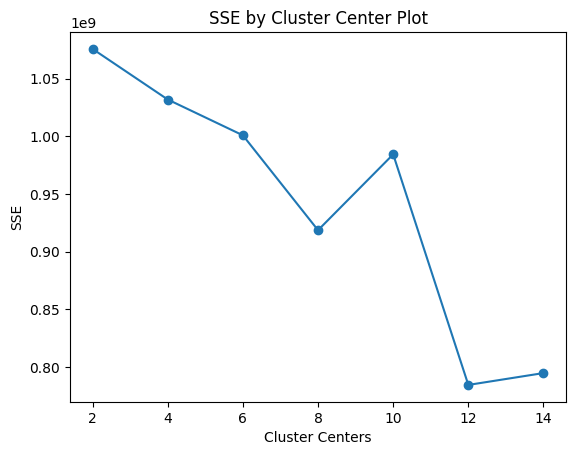

In [21]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(vectors, 15)

## K-means clustering

In [23]:
optimal_clusters = 8

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

meanshift = MeanShift()

hdensity = HDBSCAN()

agglom = AgglomerativeClustering(n_clusters=optimal_clusters)

feature_agglom = FeatureAgglomeration(n_clusters=optimal_clusters)

meanshift_clusters  = meanshift.fit_predict(vectors.toarray())

clusters = kmeans.fit_predict(vectors)

density_clusters = hdensity.fit_predict(vectors)

agglom_clusters = agglom.fit_predict(vectors.toarray())

agglom_vectors = feature_agglom.fit_transform(vectors.toarray())

feature_agglom_clusters = agglom.fit_predict(agglom_vectors)

## Plotting the clustering

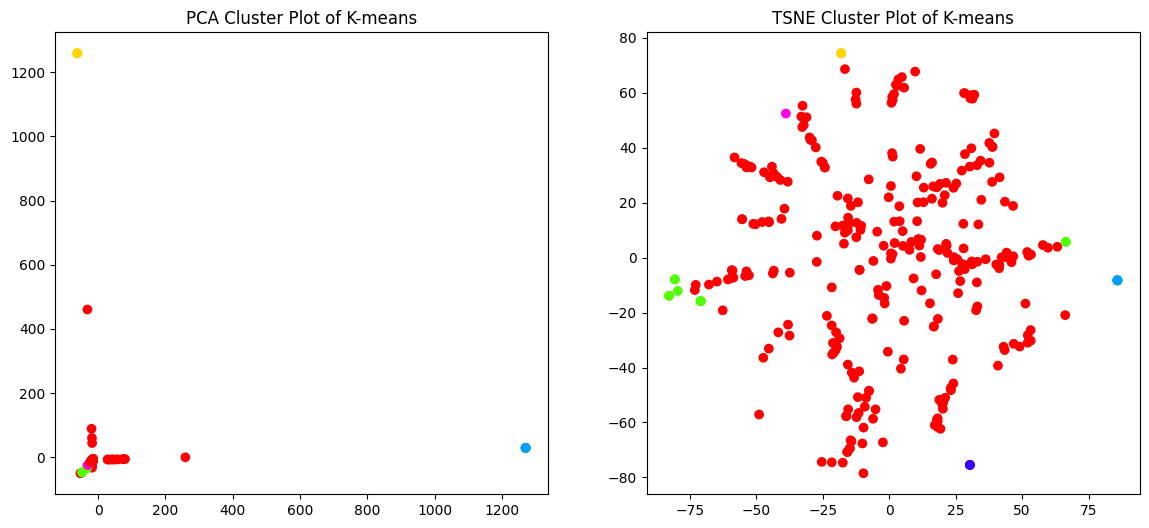

In [24]:
def plot_tsne_pca(data, labels, title=''):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].toarray())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].toarray()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot of ' + title)
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot of ' + title)
    
plot_tsne_pca(vectors, clusters, 'K-means')

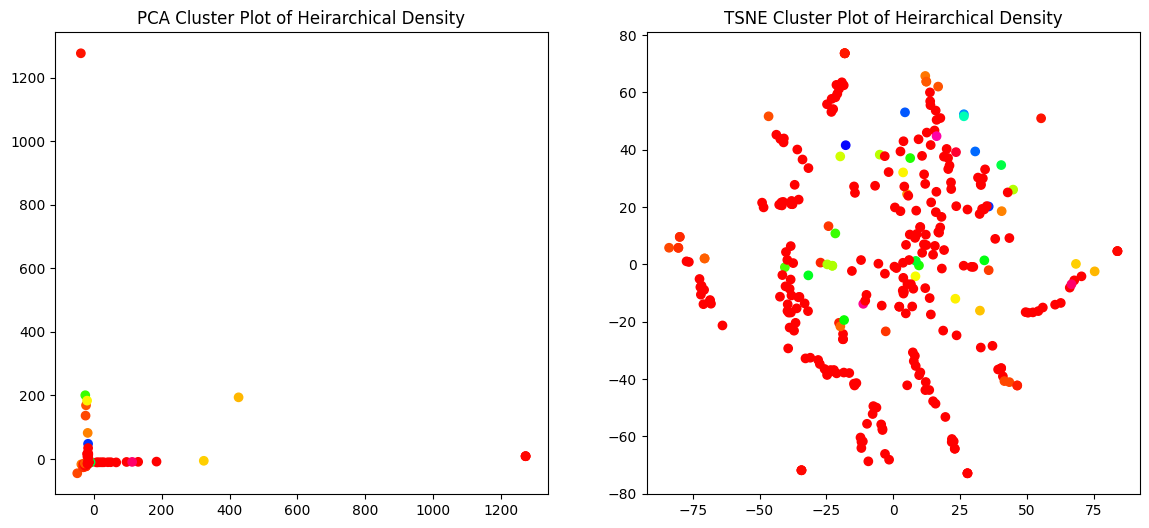

In [25]:
plot_tsne_pca(vectors, meanshift_clusters, 'Heirarchical Density')

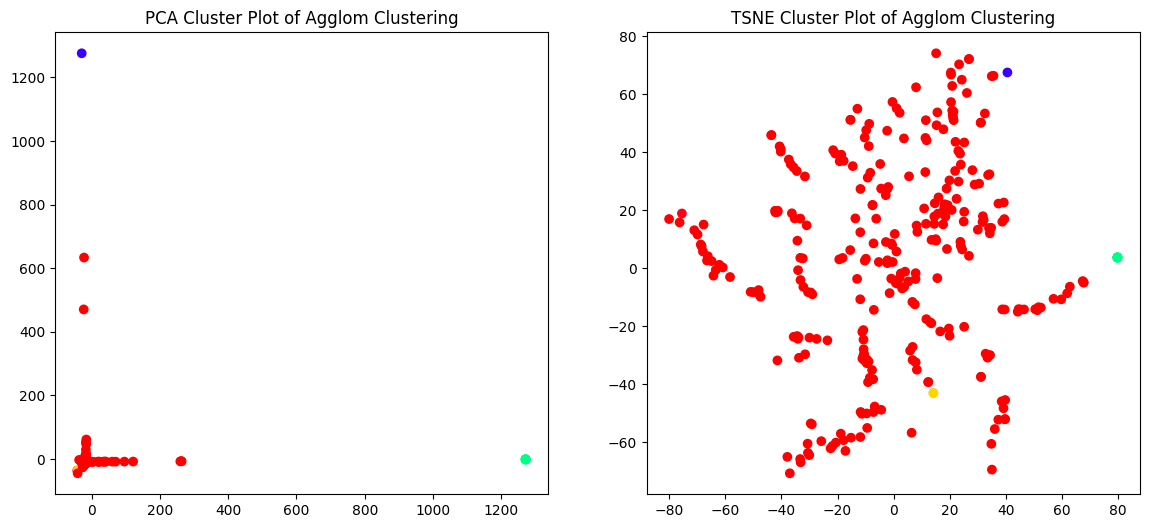

In [26]:
plot_tsne_pca(vectors, agglom_clusters, 'Agglom Clustering')

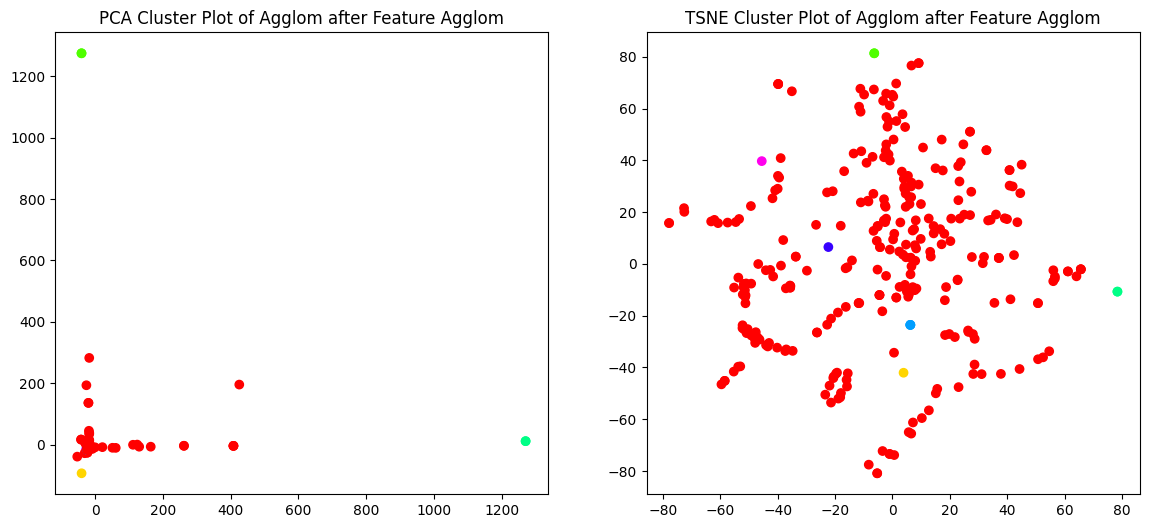

In [27]:
plot_tsne_pca(vectors, feature_agglom_clusters, 'Agglom after Feature Agglom')

In [28]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(vectors, clusters, tfidf_tokens, 3)


Cluster 0
zone, street, resident

Cluster 1
fully, zones, crosswalk

Cluster 2
blocking, street, hydrant

Cluster 3
going, zones, illegally

Cluster 4
goes, zones, sidewalk

Cluster 5
street, blocking, driveway

Cluster 6
fully, zones, double

Cluster 7
full, zones, spot


In [29]:
get_top_keywords(vectors, meanshift_clusters, tfidf_tokens, 3)


Cluster 0
hydrant, street, resident

Cluster 1
illegally, blocking, driveway

Cluster 2
goes, zones, sidewalk

Cluster 3
street, resident, sticker

Cluster 4
cars, zone, tow

Cluster 5
zones, expired, inspection

Cluster 6
going, zones, illegally

Cluster 7
illegally, street, bike

Cluster 8
zones, resident, nonresident

Cluster 9
fully, zones, crosswalk

Cluster 10
zones, resident, non

Cluster 11
zones, blocking, hydrant

Cluster 12
model, street, blocking

Cluster 13
zones, street, hydrant

Cluster 14
full, zones, spot

Cluster 15
fully, zones, unauthorized

Cluster 16
plates, registration, expired

Cluster 17
street, blocking, sidewalk

Cluster 18
fully, zones, double

Cluster 19
illegally, blocking, crosswalk

Cluster 20
fully, zones, hydrant

Cluster 21
zones, bus, stop

Cluster 22
zones, street, illegally

Cluster 23
zones, street, fire

Cluster 24
fl, zones, street

Cluster 25
zones, hydrant, fire

Cluster 26
make, zone, stopping

Cluster 27
zones, street, bus

Cluster 28
goin

In [30]:
get_top_keywords(vectors, feature_agglom_clusters, tfidf_tokens, 3)


Cluster 0
hydrant, street, resident

Cluster 1
fully, zones, crosswalk

Cluster 2
going, zones, illegally

Cluster 3
goes, zones, sidewalk

Cluster 4
fully, zones, unauthorized

Cluster 5
full, zones, spot

Cluster 6
fully, zones, double

Cluster 7
fully, zones, hydrant
